In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import re
from nltk.corpus import stopwords
import time
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.1.0


In [80]:
reviews = pd.read_csv("food review/Reviews.csv")[:35173]
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [81]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35173 entries, 0 to 35172
Data columns (total 10 columns):
Id                        35173 non-null int64
ProductId                 35173 non-null object
UserId                    35173 non-null object
ProfileName               35172 non-null object
HelpfulnessNumerator      35173 non-null int64
HelpfulnessDenominator    35173 non-null int64
Score                     35173 non-null int64
Time                      35173 non-null int64
Summary                   35172 non-null object
Text                      35173 non-null object
dtypes: int64(5), object(5)
memory usage: 2.7+ MB


In [82]:
reviews.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               1
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   1
Text                      0
dtype: int64

In [83]:

reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], 1)
reviews = reviews.dropna()
demo_summary= reviews.drop(['Text'],1)
reviews = reviews.reset_index(drop=True)


reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [84]:
reviews.isnull().sum()

Summary    0
Text       0
dtype: int64

In [85]:
reviews.shape


(35172, 2)

In [86]:
print(reviews.Summary.describe())
print()
print(reviews.Text.describe())

count          35172
unique         28194
top       Delicious!
freq             136
Name: Summary, dtype: object

count                                                 35172
unique                                                33043
top       Diamond Almonds<br />Almonds are a good source...
freq                                                     12
Name: Text, dtype: object


In [87]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [88]:
def clean_text(text, remove_stopwords):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [89]:
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(str(summary), remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(str(text), remove_stopwords=True))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [90]:
for i in range(0,5):
    print("Text: ", clean_texts[i])
    print("Summaries: ",clean_summaries[i])
    print()

Text:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summaries:  good quality dog food

Text:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summaries:  not as advertised

Text:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summaries:   delight  says it all

Text:  looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summaries:  cough medicine

Text:  great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summaries:  great taffy



In [91]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1
                
'''Find the number of times each word was used and the size of the vocabulary'''
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 37145


In [92]:
embeddings_index = {}

with open('numberbatch-en/numberbatch-en-17.02.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 484557


In [93]:
'''Find the number of words that are missing from CN, and are used more than our threshold.'''
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 251
Percent of words that are missing from vocabulary: 0.6799999999999999%


In [94]:
'''Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe'''

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))


Total number of unique words: 37145
Number of words we will use: 26955
Percent of words we will use: 72.57000000000001%


In [95]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        #embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

26955


In [96]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [97]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 1563100
Total number of UNKs in headlines: 19624
Percent of words that are UNK: 1.26%


In [98]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [99]:

lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
             counts
count  35172.000000
mean       4.177101
std        2.648076
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       30.000000

Texts:
             counts
count  35172.000000
mean      41.264500
std       39.651104
min        1.000000
25%       18.000000
50%       29.000000
75%       50.000000
max      783.000000


In [100]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [104]:
# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 199 #84
max_summary_length = 13
min_length = 2
unk_text_limit = 100 # use 1
unk_summary_limit = 100 # use 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

31084
31084


# Building the model

In [105]:
def model_inputs():
    '''Create palceholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

In [106]:
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [107]:
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state

In [108]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                           output_time_major=False,
                                                           impute_finished=True,
                                                           maximum_iterations=max_summary_length)
    return training_logits

In [109]:
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            output_time_major=False,
                                                            impute_finished=True,
                                                            maximum_iterations=max_summary_length)
    
    return inference_logits

# Applying Attention

In [110]:
#output_units=12
def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    for layer in range(num_layers):
        with tf.variable_scope('decoder_{}'.format(layer)):
            lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, 
                                                     input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    #Attention Mechanism
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')

    dec_cell = tf.contrib.seq2seq.DynamicAttentionWrapper(dec_cell,
                                                          attn_mech,
                                                          rnn_size)
            
    initial_state = tf.contrib.seq2seq.DynamicAttentionWrapperState(enc_state[0],
                                                                    _zero_state_tensors(rnn_size, 
                                                                                        batch_size, 
                                                                                        tf.float32)) 
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)

    return training_logits, inference_logits

In [111]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [112]:
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [113]:
def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

# Training the Model

In [117]:
# Set the Hyperparameters
epochs = 50 # use 100
batch_size = 64
rnn_size = 256
num_layers = 3
learning_rate = 0.008
keep_probability = 0.75

# Building the graph

In [118]:
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")

Graph is built.


# This module will train the above graph

In [119]:
# Train the Model
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 5 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(sorted_texts)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model


checkpoint = "./best_model.ckpt" 
#uncomment the above line for new training.

In [120]:
print("Training will Strat now.")
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session

    #loader = tf.train.import_meta_graph("C:/Users/shrey/OneDrive/Study/Bennett/Sem2/HPC/Project/amazon_fine_food_review_summarizer/best_model.ckpt.meta")
    #loader.restore(sess, checkpoint)
    
    #by commenting above 2 lines the code will start retrain the model. 
            
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(sorted_summaries, sorted_texts, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_texts) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
        saver = tf.train.Saver() 
        saver.save(sess, checkpoint)

        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

print("Model Trained")

Training will Strat now.
Epoch   1/50 Batch    5/485 - Loss:  6.545, Seconds: 0.49
Epoch   1/50 Batch   10/485 - Loss:  3.219, Seconds: 0.59
Epoch   1/50 Batch   15/485 - Loss:  2.987, Seconds: 0.50
Epoch   1/50 Batch   20/485 - Loss:  2.648, Seconds: 0.59
Epoch   1/50 Batch   25/485 - Loss:  2.867, Seconds: 0.48
Epoch   1/50 Batch   30/485 - Loss:  2.660, Seconds: 0.60
Epoch   1/50 Batch   35/485 - Loss:  2.695, Seconds: 0.55
Epoch   1/50 Batch   40/485 - Loss:  2.792, Seconds: 0.45
Epoch   1/50 Batch   45/485 - Loss:  2.713, Seconds: 0.58
Epoch   1/50 Batch   50/485 - Loss:  2.651, Seconds: 0.61
Epoch   1/50 Batch   55/485 - Loss:  2.683, Seconds: 0.43
Epoch   1/50 Batch   60/485 - Loss:  2.719, Seconds: 0.48
Epoch   1/50 Batch   65/485 - Loss:  2.493, Seconds: 0.51
Epoch   1/50 Batch   70/485 - Loss:  2.402, Seconds: 0.54
Epoch   1/50 Batch   75/485 - Loss:  2.748, Seconds: 0.59
Epoch   1/50 Batch   80/485 - Loss:  2.737, Seconds: 0.60
Epoch   1/50 Batch   85/485 - Loss:  2.612, Sec

Epoch   2/50 Batch  215/485 - Loss:  2.184, Seconds: 0.68
Epoch   2/50 Batch  220/485 - Loss:  2.154, Seconds: 0.72
Epoch   2/50 Batch  225/485 - Loss:  2.273, Seconds: 0.62
Epoch   2/50 Batch  230/485 - Loss:  2.177, Seconds: 0.73
Epoch   2/50 Batch  235/485 - Loss:  2.203, Seconds: 0.75
Epoch   2/50 Batch  240/485 - Loss:  2.450, Seconds: 0.62
Epoch   2/50 Batch  245/485 - Loss:  2.112, Seconds: 0.73
Epoch   2/50 Batch  250/485 - Loss:  2.120, Seconds: 0.80
Epoch   2/50 Batch  255/485 - Loss:  2.281, Seconds: 0.91
Epoch   2/50 Batch  260/485 - Loss:  2.410, Seconds: 0.81
Epoch   2/50 Batch  265/485 - Loss:  2.288, Seconds: 0.70
Epoch   2/50 Batch  270/485 - Loss:  2.322, Seconds: 0.76
Epoch   2/50 Batch  275/485 - Loss:  2.168, Seconds: 0.79
Epoch   2/50 Batch  280/485 - Loss:  2.189, Seconds: 0.87
Epoch   2/50 Batch  285/485 - Loss:  2.353, Seconds: 0.80
Epoch   2/50 Batch  290/485 - Loss:  2.154, Seconds: 0.81
Epoch   2/50 Batch  295/485 - Loss:  2.058, Seconds: 0.87
Epoch   2/50 B

Epoch   3/50 Batch  425/485 - Loss:  2.274, Seconds: 1.12
Epoch   3/50 Batch  430/485 - Loss:  2.371, Seconds: 1.20
Epoch   3/50 Batch  435/485 - Loss:  2.474, Seconds: 1.24
Epoch   3/50 Batch  440/485 - Loss:  2.513, Seconds: 1.29
Epoch   3/50 Batch  445/485 - Loss:  2.453, Seconds: 1.28
Epoch   3/50 Batch  450/485 - Loss:  2.467, Seconds: 1.31
Epoch   3/50 Batch  455/485 - Loss:  2.367, Seconds: 1.38
Epoch   3/50 Batch  460/485 - Loss:  2.679, Seconds: 1.43
Epoch   3/50 Batch  465/485 - Loss:  2.521, Seconds: 1.55
Epoch   3/50 Batch  470/485 - Loss:  2.669, Seconds: 1.69
Epoch   3/50 Batch  475/485 - Loss:  2.615, Seconds: 1.83
Epoch   3/50 Batch  480/485 - Loss:  2.676, Seconds: 1.90
Average loss for this update: 2.351
No Improvement.
Epoch   4/50 Batch    5/485 - Loss:  2.382, Seconds: 0.50
Epoch   4/50 Batch   10/485 - Loss:  1.798, Seconds: 0.54
Epoch   4/50 Batch   15/485 - Loss:  1.759, Seconds: 0.51
Epoch   4/50 Batch   20/485 - Loss:  1.644, Seconds: 0.60
Epoch   4/50 Batch  

Epoch   5/50 Batch  155/485 - Loss:  1.744, Seconds: 0.67
Epoch   5/50 Batch  160/485 - Loss:  1.589, Seconds: 0.59
Average loss for this update: 1.724
New Record!
Epoch   5/50 Batch  165/485 - Loss:  1.772, Seconds: 0.61
Epoch   5/50 Batch  170/485 - Loss:  1.783, Seconds: 0.64
Epoch   5/50 Batch  175/485 - Loss:  1.592, Seconds: 0.71
Epoch   5/50 Batch  180/485 - Loss:  1.695, Seconds: 0.80
Epoch   5/50 Batch  185/485 - Loss:  1.771, Seconds: 0.65
Epoch   5/50 Batch  190/485 - Loss:  1.743, Seconds: 0.78
Epoch   5/50 Batch  195/485 - Loss:  1.760, Seconds: 0.65
Epoch   5/50 Batch  200/485 - Loss:  1.865, Seconds: 0.65
Epoch   5/50 Batch  205/485 - Loss:  1.828, Seconds: 0.62
Epoch   5/50 Batch  210/485 - Loss:  1.837, Seconds: 0.81
Epoch   5/50 Batch  215/485 - Loss:  1.785, Seconds: 0.71
Epoch   5/50 Batch  220/485 - Loss:  1.771, Seconds: 0.80
Epoch   5/50 Batch  225/485 - Loss:  1.846, Seconds: 0.63
Epoch   5/50 Batch  230/485 - Loss:  1.772, Seconds: 0.86
Epoch   5/50 Batch  235/

Epoch   6/50 Batch  360/485 - Loss:  1.848, Seconds: 0.98
Epoch   6/50 Batch  365/485 - Loss:  1.987, Seconds: 1.03
Epoch   6/50 Batch  370/485 - Loss:  1.990, Seconds: 0.96
Epoch   6/50 Batch  375/485 - Loss:  2.025, Seconds: 0.95
Epoch   6/50 Batch  380/485 - Loss:  1.946, Seconds: 1.01
Epoch   6/50 Batch  385/485 - Loss:  1.958, Seconds: 0.97
Epoch   6/50 Batch  390/485 - Loss:  1.833, Seconds: 1.06
Epoch   6/50 Batch  395/485 - Loss:  2.050, Seconds: 0.98
Epoch   6/50 Batch  400/485 - Loss:  1.991, Seconds: 1.05
Epoch   6/50 Batch  405/485 - Loss:  1.947, Seconds: 1.10
Epoch   6/50 Batch  410/485 - Loss:  1.929, Seconds: 1.15
Epoch   6/50 Batch  415/485 - Loss:  2.079, Seconds: 1.22
Epoch   6/50 Batch  420/485 - Loss:  2.124, Seconds: 1.22
Epoch   6/50 Batch  425/485 - Loss:  1.967, Seconds: 1.17
Epoch   6/50 Batch  430/485 - Loss:  2.077, Seconds: 1.27
Epoch   6/50 Batch  435/485 - Loss:  2.162, Seconds: 2.51
Epoch   6/50 Batch  440/485 - Loss:  2.174, Seconds: 1.29
Epoch   6/50 B

Epoch   8/50 Batch   90/485 - Loss:  1.449, Seconds: 0.53
Epoch   8/50 Batch   95/485 - Loss:  1.435, Seconds: 0.56
Epoch   8/50 Batch  100/485 - Loss:  1.328, Seconds: 0.74
Epoch   8/50 Batch  105/485 - Loss:  1.405, Seconds: 0.77
Epoch   8/50 Batch  110/485 - Loss:  1.425, Seconds: 0.65
Epoch   8/50 Batch  115/485 - Loss:  1.549, Seconds: 0.68
Epoch   8/50 Batch  120/485 - Loss:  1.421, Seconds: 0.64
Epoch   8/50 Batch  125/485 - Loss:  1.483, Seconds: 0.59
Epoch   8/50 Batch  130/485 - Loss:  1.423, Seconds: 0.60
Epoch   8/50 Batch  135/485 - Loss:  1.481, Seconds: 0.71
Epoch   8/50 Batch  140/485 - Loss:  1.587, Seconds: 0.66
Epoch   8/50 Batch  145/485 - Loss:  1.469, Seconds: 0.66
Epoch   8/50 Batch  150/485 - Loss:  1.533, Seconds: 0.69
Epoch   8/50 Batch  155/485 - Loss:  1.497, Seconds: 0.74
Epoch   8/50 Batch  160/485 - Loss:  1.412, Seconds: 0.59
Average loss for this update: 1.478
New Record!
Epoch   8/50 Batch  165/485 - Loss:  1.510, Seconds: 0.62
Epoch   8/50 Batch  170/

Epoch   9/50 Batch  300/485 - Loss:  1.459, Seconds: 0.85
Epoch   9/50 Batch  305/485 - Loss:  1.600, Seconds: 0.83
Epoch   9/50 Batch  310/485 - Loss:  1.624, Seconds: 0.74
Epoch   9/50 Batch  315/485 - Loss:  1.623, Seconds: 0.82
Epoch   9/50 Batch  320/485 - Loss:  1.655, Seconds: 0.88
Average loss for this update: 1.522
No Improvement.
Epoch   9/50 Batch  325/485 - Loss:  1.752, Seconds: 0.74
Epoch   9/50 Batch  330/485 - Loss:  1.468, Seconds: 0.94
Epoch   9/50 Batch  335/485 - Loss:  1.692, Seconds: 0.90
Epoch   9/50 Batch  340/485 - Loss:  1.677, Seconds: 0.85
Epoch   9/50 Batch  345/485 - Loss:  1.691, Seconds: 0.86
Epoch   9/50 Batch  350/485 - Loss:  1.781, Seconds: 0.87
Epoch   9/50 Batch  355/485 - Loss:  1.619, Seconds: 0.94
Epoch   9/50 Batch  360/485 - Loss:  1.636, Seconds: 0.99
Epoch   9/50 Batch  365/485 - Loss:  1.747, Seconds: 0.99
Epoch   9/50 Batch  370/485 - Loss:  1.725, Seconds: 0.96
Epoch   9/50 Batch  375/485 - Loss:  1.780, Seconds: 1.01
Epoch   9/50 Batch  

Epoch  11/50 Batch   25/485 - Loss:  1.619, Seconds: 0.42
Epoch  11/50 Batch   30/485 - Loss:  1.534, Seconds: 0.59
Epoch  11/50 Batch   35/485 - Loss:  1.611, Seconds: 0.57
Epoch  11/50 Batch   40/485 - Loss:  1.606, Seconds: 0.44
Epoch  11/50 Batch   45/485 - Loss:  1.554, Seconds: 0.57
Epoch  11/50 Batch   50/485 - Loss:  1.571, Seconds: 0.63
Epoch  11/50 Batch   55/485 - Loss:  1.499, Seconds: 0.42
Epoch  11/50 Batch   60/485 - Loss:  1.498, Seconds: 0.43
Epoch  11/50 Batch   65/485 - Loss:  1.423, Seconds: 0.50
Epoch  11/50 Batch   70/485 - Loss:  1.359, Seconds: 0.53
Epoch  11/50 Batch   75/485 - Loss:  1.558, Seconds: 0.59
Epoch  11/50 Batch   80/485 - Loss:  1.426, Seconds: 0.57
Epoch  11/50 Batch   85/485 - Loss:  1.441, Seconds: 0.56
Epoch  11/50 Batch   90/485 - Loss:  1.484, Seconds: 0.53
Epoch  11/50 Batch   95/485 - Loss:  1.447, Seconds: 0.56
Epoch  11/50 Batch  100/485 - Loss:  1.341, Seconds: 0.69
Epoch  11/50 Batch  105/485 - Loss:  1.436, Seconds: 0.69
Epoch  11/50 B

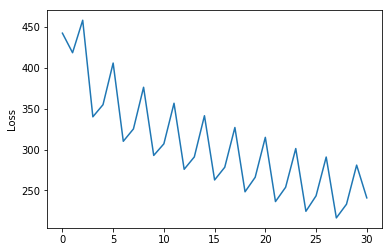

In [121]:
import matplotlib.pyplot as plt

#print("Summary updated loss:", summary_update_loss[:])
#print("Updated loss: ", update_loss)

plt.plot(summary_update_loss[:])
plt.ylabel('Loss')
plt.show()

# Testing the Model

In [122]:
def text_to_seq(text):
    '''Prepare the text for the model'''
    
    text = clean_text(text, remove_stopwords=True)
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

In [123]:
count=35
sum_F=12.346860213552002
avg_F=0.3527674346729143

In [124]:
import time

In [125]:
count=count-1
print(count)

34


In [127]:
count=count+1


##Create your own review or use one from the dataset
#input_sentence = "The packaging and everything was intact, but the yeast I got expired on 12/16.. Not sure if this is still good to use?"
#text = text_to_seq(input_sentence)

##Comment the following 3 lines if using custom Summary and text
random = np.random.randint(0,25389) #len(clean_texts))
input_sentence = clean_texts[random]
text = text_to_seq(clean_texts[random])

print("Cleaned Text", text)

checkpoint = "./best_model.ckpt"

start_time=time.time()

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    ## Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
##    Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,8)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

## Remove the padding from the summary
pad = vocab_to_int["<PAD>"] 

elapsed_time=time.time()-start_time

##for custom summary and text, comment this line.
print("Index Value: ",random)

##for custom summary and text use "input_sequence" as parameter insted of "reviews.Text.loc[random]"
print('\nOriginal Text:',reviews.Text.loc[random]) #input_sentence) #

##for custom orignal summary and text uncomment the next line and comment the next to next line.
#ogSum="Expired yeast!"
ogSum=reviews.Summary.loc[random]
ogFile=open("Testing/text.001.txt",'w')
ogFile.write(ogSum)
print("File Written to text.001.txt")
ogFile.close()

print('\nOrignal Summary: ',ogSum)

print('\nText')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([int_to_vocab[i] for i in text])))

print('\nSummary')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))

predSum=" ".join([int_to_vocab[i] for i in answer_logits if i != pad])
predFile=open("Testing/text.A.001.txt",'w')
predFile.write(predSum)
print("File Written to text.A.001.txt")
predFile.close()

print("  Response Words: ",predSum)
print("Time: ", elapsed_time)

Cleaned Text [1511, 94, 174, 485, 2275, 8183, 11707, 14912, 22129, 18367, 2094, 63, 485, 9079, 4103, 1168, 2837, 158, 1439, 8649, 867, 8625, 2500, 21915, 22130, 9492, 7894, 7953, 174, 59, 18, 7481, 0, 613, 5668, 68, 6108, 17678, 14237, 1961, 12776, 174, 745, 9690, 2295, 68, 14346, 2455, 17678, 10949, 14184, 29, 174, 1, 444, 1086, 3016, 174, 476, 174, 1309, 10132, 10219, 3260, 4778, 648, 8929, 3016, 3857, 18496, 1609, 68, 3560, 1176, 1248, 147, 1, 1773, 4522, 8054, 1905, 11364, 438, 174, 722, 686, 370, 174, 3016, 4527, 1328, 3016, 1854, 3450, 2320, 379, 613, 117, 609, 1176, 4466, 22131, 115, 2152, 4304, 8252, 815, 1466, 9267, 1954, 174, 5902, 806, 1786, 21, 372, 1609]
INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Index Value:  18978

Original Text: If you try to buy tea in one of our major cities and are approached by some limp-wristed purveyor trying to sell you one of his "artisanal" blends packaged in a paper bag with an attractive or colorful label, do not scoff but le